# Modelling

Purpose:
* develop baseline models using Prophet and ARIMA to determine which one should be used for optimization.
  

In [6]:
# data cleaning 
import pandas as pd
import datetime as dt
import numpy as np

# visualizations
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

In [7]:
# modelling - prophet
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics


# modelling - other
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
# import statsmodels.API as sm

# modelling - arima 
from pmdarima import auto_arima
from pmdarima.arima import ADFTest

In [8]:
# adjust settings 
sns.set_theme(style='whitegrid', context='talk')
#surpress scientific notation
pd.options.display.float_format = '{:,.2f}'.format
import warnings; 
warnings.simplefilter('ignore')

In [9]:
# import model data log
data_log = pd.read_csv('data/model_data_log.csv')
# data_log
# import model data in dollars

model_data_grouped = pd.read_csv('data/model_data_grouped.csv')
# model_data_grouped

## Baseline Model 1: Prophet

In [10]:
def df_year_filter(df_name, start_year, end_year):
    ''' filters data based on period year for modelling
    '''
    df_name['ds'] = pd.to_datetime(df_name['ds'])
    result = df_name.loc[(df_name['ds'].dt.year >= start_year) & (df_name['ds'].dt.year <= end_year)].reset_index(drop=True)
    return result

In [1]:
# create train data set for years 1988 to 2017, will predict years 2018,2019
train_data = df_year_filter(data_log, start_year=1988, end_year=2017)
train_data

NameError: name 'df_year_filter' is not defined

In [2]:
test_data = df_year_filter(data_log, start_year=2018, end_year=2019)
test_data

NameError: name 'df_year_filter' is not defined

In [8]:
# initialise model, no custom params
m=Prophet()

# initialise model, with best params from earlier gridsearch
# m=Prophet(changepoint_prior_scale = 5,seasonality_prior_scale=0.1,seasonality_mode='multiplicative',yearly_seasonality=True)
# fit train data to model
m.fit(train_data)

09:54:26 - cmdstanpy - INFO - Chain [1] start processing
09:54:26 - cmdstanpy - INFO - Chain [1] done processing


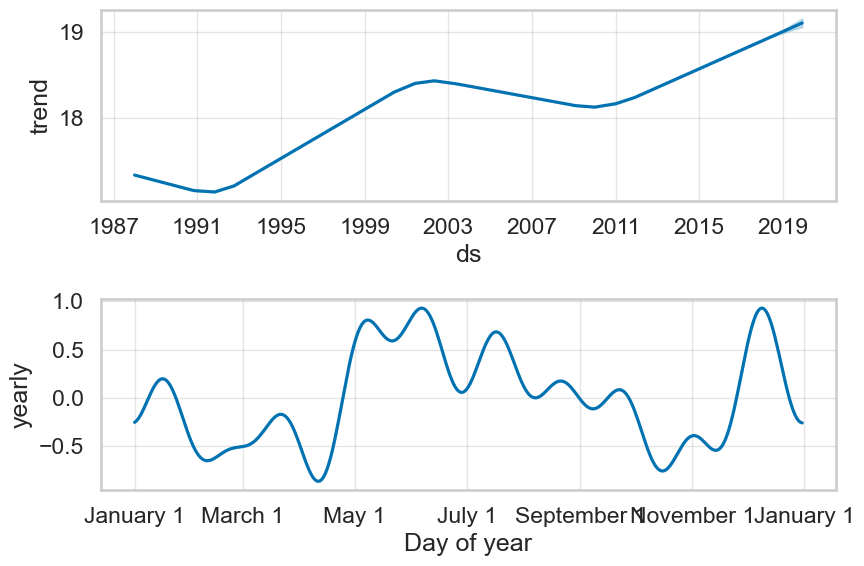

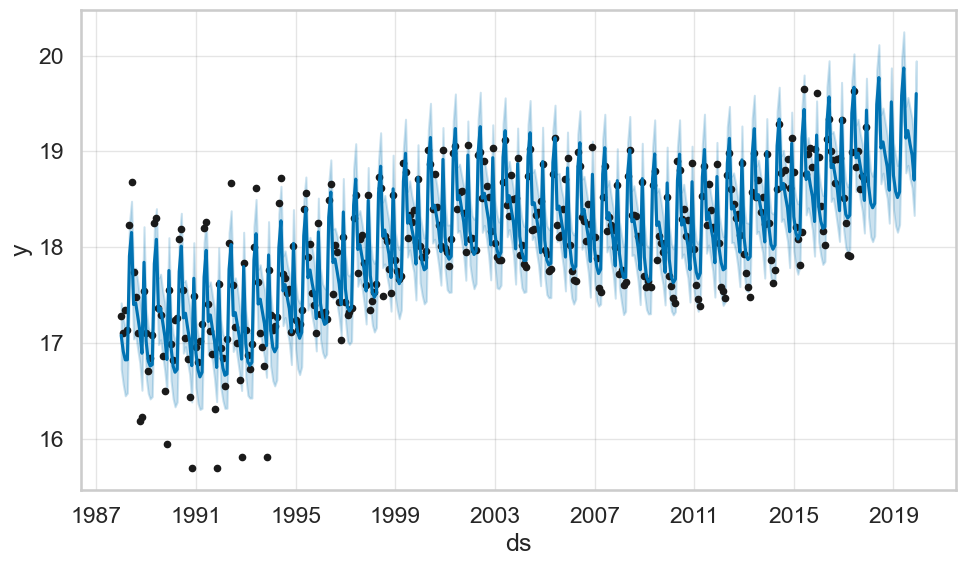

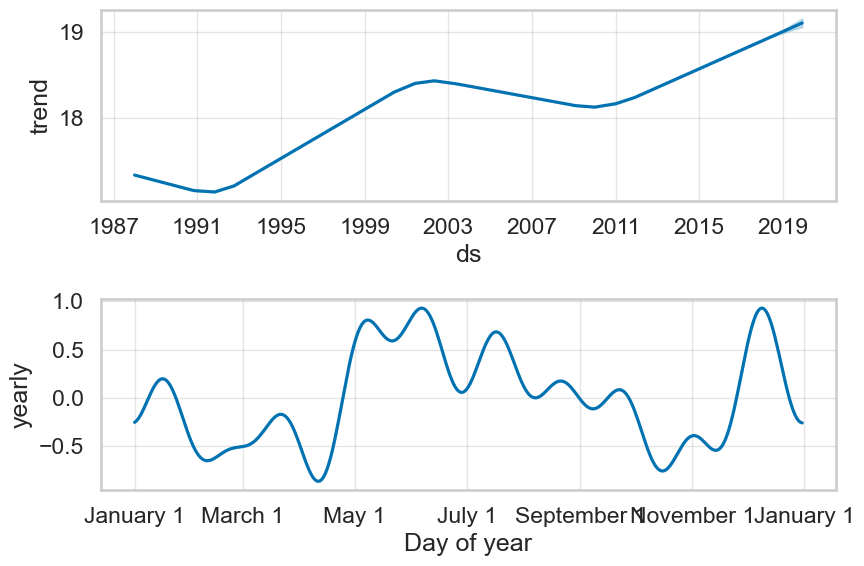

In [9]:
# predict 2018, 2019

future = m.make_future_dataframe(periods = 24, freq="MS")
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

In [10]:
forecast = m.predict(future)
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predictions

ds  yhat  yhat_lower  yhat_upper
0   1988-01-01 17.08       16.73       17.41
1   1988-02-01 16.91       16.56       17.26
2   1988-03-01 16.82       16.46       17.17
3   1988-04-01 16.82       16.48       17.17
4   1988-05-01 17.91       17.56       18.27
..         ...   ...         ...         ...
379 2019-08-01 19.22       18.86       19.60
380 2019-09-01 19.08       18.73       19.41
381 2019-10-01 18.96       18.60       19.31
382 2019-11-01 18.70       18.34       19.05
383 2019-12-01 19.60       19.25       19.96

[384 rows x 4 columns]

In [11]:
# get actual values for each period, between 1988 and 2017, values in LOG 
actuals = df_year_filter(data_log, 1988, 2019)
actuals = actuals.rename(columns={'y': 'y-actual'})
actuals

ds  y-actual
0   1988-01-01     17.28
1   1988-02-01     17.11
2   1988-03-01     17.34
3   1988-04-01     17.13
4   1988-05-01     18.23
..         ...       ...
379 2019-08-01     19.06
380 2019-09-01     18.96
381 2019-10-01     18.92
382 2019-11-01     18.72
383 2019-12-01     19.40

[384 rows x 2 columns]

In [12]:
# join actual values and predicted values into one DF
model_eval = predictions.merge(actuals, on='ds', how = 'inner')
model_eval = model_eval.rename(columns={'yhat': 'y-predicted'})
model_eval

ds  y-predicted  yhat_lower  yhat_upper  y-actual
0   1988-01-01        17.08       16.73       17.41     17.28
1   1988-02-01        16.91       16.56       17.26     17.11
2   1988-03-01        16.82       16.46       17.17     17.34
3   1988-04-01        16.82       16.48       17.17     17.13
4   1988-05-01        17.91       17.56       18.27     18.23
..         ...          ...         ...         ...       ...
379 2019-08-01        19.22       18.86       19.60     19.06
380 2019-09-01        19.08       18.73       19.41     18.96
381 2019-10-01        18.96       18.60       19.31     18.92
382 2019-11-01        18.70       18.34       19.05     18.72
383 2019-12-01        19.60       19.25       19.96     19.40

[384 rows x 5 columns]

### Evaluate Model Performance

In [13]:
# return vals to original, take exponent
model_eval_exp = model_eval.copy()
model_eval_exp

ds  y-predicted  yhat_lower  yhat_upper  y-actual
0   1988-01-01        17.08       16.73       17.41     17.28
1   1988-02-01        16.91       16.56       17.26     17.11
2   1988-03-01        16.82       16.46       17.17     17.34
3   1988-04-01        16.82       16.48       17.17     17.13
4   1988-05-01        17.91       17.56       18.27     18.23
..         ...          ...         ...         ...       ...
379 2019-08-01        19.22       18.86       19.60     19.06
380 2019-09-01        19.08       18.73       19.41     18.96
381 2019-10-01        18.96       18.60       19.31     18.92
382 2019-11-01        18.70       18.34       19.05     18.72
383 2019-12-01        19.60       19.25       19.96     19.40

[384 rows x 5 columns]

In [14]:
# return values to original non - log $
model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']] = np.exp(model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']])

In [15]:
model_eval_exp

ds    y-predicted     yhat_lower     yhat_upper       y-actual
0   1988-01-01  26,125,427.81  18,415,910.16  36,429,008.36  32,094,345.55
1   1988-02-01  22,072,594.23  15,483,716.90  31,475,406.66  26,852,319.99
2   1988-03-01  20,225,349.91  14,140,457.82  28,663,018.98  34,003,540.09
3   1988-04-01  20,240,672.14  14,321,229.69  28,697,393.08  27,637,080.92
4   1988-05-01  59,779,802.07  42,311,115.22  85,949,541.69  82,665,791.27
..         ...            ...            ...            ...            ...
379 2019-08-01 221,450,826.28 155,452,676.04 326,823,720.54 190,136,068.39
380 2019-09-01 192,477,647.44 136,314,728.37 269,934,741.55 172,289,856.95
381 2019-10-01 171,613,607.06 119,326,776.59 242,241,968.06 165,147,457.37
382 2019-11-01 132,153,630.87  92,463,169.84 188,433,791.04 135,296,729.64
383 2019-12-01 325,911,173.30 228,990,957.20 468,047,970.46 265,026,569.75

[384 rows x 5 columns]

#### Visualise Actuals vs Prediction

In [16]:
preds1 = df_year_filter(model_eval_exp, 2018, 2019)['ds']
preds1

0    2018-01-01
1    2018-02-01
2    2018-03-01
3    2018-04-01
4    2018-05-01
5    2018-06-01
6    2018-07-01
7    2018-08-01
8    2018-09-01
9    2018-10-01
10   2018-11-01
11   2018-12-01
12   2019-01-01
13   2019-02-01
14   2019-03-01
15   2019-04-01
16   2019-05-01
17   2019-06-01
18   2019-07-01
19   2019-08-01
20   2019-09-01
21   2019-10-01
22   2019-11-01
23   2019-12-01
Name: ds, dtype: datetime64[ns]

In [17]:
## plot predicted values against actuals, for test range (2018 and 2019 only)
fig = go.Figure()
x_vals1 = df_year_filter(model_eval_exp, 2018, 2019)['ds']


# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= model_eval_exp['y-predicted'], name = 'Predicted'
))
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= model_eval_exp['y-actual'], name = 'Actuals'
))

fig.update_layout(title='Actual vs Predicted')

fig.add_trace(go.Scatter(x=x_vals1, y=model_eval_exp['yhat_upper'],
    fill=None,
    mode='lines',
    line_color='royalblue',line_width=0, name='Predicted Lower'
    ))
fig.add_trace(go.Scatter(
    x=x_vals1, y=model_eval_exp['yhat_lower'],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='royalblue', line_width=0, name='Predicted Upper'))

fig.show()

## Baseline Model 2: Arima

In [18]:
arima_train = train_data.set_index('ds')
arima_test = test_data.set_index('ds')

In [19]:
arima_data = model_data_grouped.set_index('ds')
arima_data

y
ds                       
1988-01-01  32,094,345.55
1988-02-01  26,852,319.99
1988-03-01  34,003,540.09
1988-04-01  27,637,080.92
1988-05-01  82,665,791.27
...                   ...
2022-08-01 152,486,864.49
2022-09-01 124,696,349.31
2022-10-01 118,856,472.23
2022-11-01  84,952,911.97
2022-12-01 129,159,026.77

[420 rows x 1 columns]

In [20]:
arima_test

y
ds              
2018-01-01 18.55
2018-02-01 18.41
2018-03-01 18.03
2018-04-01 17.95
2018-05-01 19.18
2018-06-01 19.62
2018-07-01 18.96
2018-08-01 19.17
2018-09-01 18.85
2018-10-01 18.84
2018-11-01 18.34
2018-12-01 18.95
2019-01-01 18.48
2019-02-01 18.09
2019-03-01 17.99
2019-04-01 17.72
2019-05-01 19.16
2019-06-01 19.67
2019-07-01 18.91
2019-08-01 19.06
2019-09-01 18.96
2019-10-01 18.92
2019-11-01 18.72
2019-12-01 19.40

In [21]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(arima_data)

(0.01, False)

In [22]:
# ARIMA 'customized'
# arima_model = auto_arima(arima_train, start_p = 0, start_q = 0,
#                          max_p = 5, max_d = 5, max_q = 5, start_P = 0, 
#                          D =1, start_Q = 0, max_P=5,
#                          max_D=5, max_Q = 5, m = 12, seasonal=True, 
#                          error_action = 'warn', trace = True,
#                          surpress_warnings = True, stepwise=True,
#                          random_state=20, n_fits = 50)

In [23]:
# ARIMA MOST BASIC - data not stationary... 
arima_model = auto_arima(arima_train, random_state=20,trace = True
                         )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=480.117, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=643.621, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=631.806, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=579.142, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=641.652, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=524.242, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=521.534, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=486.664, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=528.217, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=530.201, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=526.259, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=520.080, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=479.390, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=526.510, 

In [24]:

# In-sample forecast for the training range (1988 - 2017)
in_sample_forecast, conf_int = arima_model.predict_in_sample(end=len(train_data)-1, return_conf_int=True)

# Out-of-sample forecast for the test range (2018 - 2019)
out_of_sample_forecast, out_of_sample_conf_int = arima_model.predict(n_periods=len(test_data), return_conf_int=True)

# Create DataFrames to store the forecast results
training_preds = pd.DataFrame({'date': arima_train.index, 'prediction': in_sample_forecast, 'lower': conf_int[:, 0], 'upper': conf_int[:, 1]})
training_preds.set_index('date', inplace=True)

testing_preds = pd.DataFrame({'date': arima_test.index, 'prediction': out_of_sample_forecast, 'lower': out_of_sample_conf_int[:, 0], 'upper': out_of_sample_conf_int[:, 1]})
testing_preds.set_index('date', inplace=True)

In [25]:
training_preds

prediction     lower    upper
date                                     
1988-01-01        0.00 -1,959.96 1,959.96
1988-02-01       17.28     16.13    18.44
1988-03-01       17.14     16.00    18.27
1988-04-01       17.33     16.22    18.44
1988-05-01       17.17     16.09    18.25
...                ...       ...      ...
2017-08-01       18.87     17.96    19.77
2017-09-01       18.87     17.96    19.77
2017-10-01       18.64     17.73    19.55
2017-11-01       18.69     17.78    19.60
2017-12-01       18.65     17.75    19.56

[360 rows x 3 columns]

In [26]:
full_arima_preds = pd.concat([training_preds, testing_preds])
full_arima_preds

prediction     lower    upper
date                                     
1988-01-01        0.00 -1,959.96 1,959.96
1988-02-01       17.28     16.13    18.44
1988-03-01       17.14     16.00    18.27
1988-04-01       17.33     16.22    18.44
1988-05-01       17.17     16.09    18.25
...                ...       ...      ...
2019-08-01       18.71     17.61    19.81
2019-09-01       18.71     17.61    19.82
2019-10-01       18.71     17.60    19.82
2019-11-01       18.71     17.59    19.83
2019-12-01       18.71     17.59    19.83

[384 rows x 3 columns]

In [27]:
# full_arima_preds = full_arima_preds.reset_index()
full_arima_preds = full_arima_preds.rename(columns={'prediction':'predicted_value_arima','lower':'predicted_value_arima_lower','upper':'predicted_value_arima_upper'})
full_arima_preds

predicted_value_arima  predicted_value_arima_lower  \
date                                                             
1988-01-01                   0.00                    -1,959.96   
1988-02-01                  17.28                        16.13   
1988-03-01                  17.14                        16.00   
1988-04-01                  17.33                        16.22   
1988-05-01                  17.17                        16.09   
...                           ...                          ...   
2019-08-01                  18.71                        17.61   
2019-09-01                  18.71                        17.61   
2019-10-01                  18.71                        17.60   
2019-11-01                  18.71                        17.59   
2019-12-01                  18.71                        17.59   

            predicted_value_arima_upper  
date                                     
1988-01-01                     1,959.96  
1988-02-01                        18.44  
1988-03-01                        18.27  
1988-04-01                        18.44  
1988-05-01                        18.25  
...                                 ...  
2019-08-01                        19.81  
2019-09-01                        19.82  
2019-10-01                        19.82  
2019-11-01                        19.83  
2019-12-01                        19.83  

[384 rows x 3 columns]

In [28]:
arima_prediction_exp = full_arima_preds.copy()
arima_prediction_exp = np.exp(arima_prediction_exp)
arima_prediction_exp = arima_prediction_exp.reset_index()
arima_prediction_exp = arima_prediction_exp.rename(columns={'date':'ds'})
arima_prediction_exp

ds  predicted_value_arima  predicted_value_arima_lower  \
0   1988-01-01                   1.00                         0.00   
1   1988-02-01          32,094,311.86                10,106,523.13   
2   1988-03-01          27,702,148.64                 8,879,877.63   
3   1988-04-01          33,617,357.15                11,073,968.32   
4   1988-05-01          28,540,056.16                 9,679,660.25   
..         ...                    ...                          ...   
379 2019-08-01         133,640,053.42                44,527,061.75   
380 2019-09-01         133,670,228.93                44,279,660.41   
381 2019-10-01         133,656,516.46                44,018,881.71   
382 2019-11-01         133,623,414.27                43,755,062.37   
383 2019-12-01         133,589,195.63                43,495,144.97   

     predicted_value_arima_upper  
0                            inf  
1                 101,918,814.28  
2                  86,421,127.77  
3                 102,052,549.64  
4                  84,149,111.08  
..                           ...  
379               401,096,842.59  
380               403,520,034.63  
381               405,827,310.85  
382               408,072,023.52  
383               410,300,349.65  

[384 rows x 4 columns]

## Ensemble : Arima and Prophet
* simple: take mean of arima and prophet. 

In [29]:
# merge arima prediction and prophet prediction

df_compare = model_eval_exp.merge(arima_prediction_exp, on = 'ds', how='left').iloc[1:,:].reset_index(drop=True)
# drop first row since arima didn't predict for first period 
# df_compare

# df_compare
df_compare = df_compare[['ds','y-predicted','predicted_value_arima','y-actual',]]
df_compare

ds    y-predicted  predicted_value_arima       y-actual
0   1988-02-01  22,072,594.23          32,094,311.86  26,852,319.99
1   1988-03-01  20,225,349.91          27,702,148.64  34,003,540.09
2   1988-04-01  20,240,672.14          33,617,357.15  27,637,080.92
3   1988-05-01  59,779,802.07          28,540,056.16  82,665,791.27
4   1988-06-01  76,464,178.13          61,034,189.84 130,102,650.00
..         ...            ...                    ...            ...
378 2019-08-01 221,450,826.28         133,640,053.42 190,136,068.39
379 2019-09-01 192,477,647.44         133,670,228.93 172,289,856.95
380 2019-10-01 171,613,607.06         133,656,516.46 165,147,457.37
381 2019-11-01 132,153,630.87         133,623,414.27 135,296,729.64
382 2019-12-01 325,911,173.30         133,589,195.63 265,026,569.75

[383 rows x 4 columns]

In [42]:
# ensemble take mean of prophet and arima 
df_compare['ensemble-pred'] = df_compare[['y-predicted', 'predicted_value_arima']].mean(axis=1)
df_compare

ds    y-predicted  predicted_value_arima       y-actual  \
0   1988-02-01  22,072,594.23          32,094,311.86  26,852,319.99   
1   1988-03-01  20,225,349.91          27,702,148.64  34,003,540.09   
2   1988-04-01  20,240,672.14          33,617,357.15  27,637,080.92   
3   1988-05-01  59,779,802.07          28,540,056.16  82,665,791.27   
4   1988-06-01  76,464,178.13          61,034,189.84 130,102,650.00   
..         ...            ...                    ...            ...   
378 2019-08-01 221,450,826.28         133,640,053.42 190,136,068.39   
379 2019-09-01 192,477,647.44         133,670,228.93 172,289,856.95   
380 2019-10-01 171,613,607.06         133,656,516.46 165,147,457.37   
381 2019-11-01 132,153,630.87         133,623,414.27 135,296,729.64   
382 2019-12-01 325,911,173.30         133,589,195.63 265,026,569.75   

     ensemble-pred  
0    27,083,453.05  
1    23,963,749.27  
2    26,929,014.65  
3    44,159,929.11  
4    68,749,183.98  
..             ...  
378 177,545,439.85  
379 163,073,938.19  
380 152,635,061.76  
381 132,888,522.57  
382 229,750,184.47  

[383 rows x 5 columns]

## Lin Reg Baseline

In [50]:
# train_data
# test_data

In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assume 'df' is your time series data in a pandas DataFrame with a column 'target' to predict
# Feature engineering: Create lag features
data_log_lr = data_log.copy()
data_log_lr['lag1'] = data_log_lr['y'].shift(1)
data_log_lr['lag2'] = data_log_lr['y'].shift(2)
data_log_lr['lag3'] = data_log_lr['y'].shift(2)
data_log_lr



ds     y  lag1  lag2  lag3
0   1988-01-01 17.28   NaN   NaN   NaN
1   1988-02-01 17.11 17.28   NaN   NaN
2   1988-03-01 17.34 17.11 17.28 17.28
3   1988-04-01 17.13 17.34 17.11 17.11
4   1988-05-01 18.23 17.13 17.34 17.34
..         ...   ...   ...   ...   ...
415 2022-08-01 18.84 18.99 19.71 19.71
416 2022-09-01 18.64 18.84 18.99 18.99
417 2022-10-01 18.59 18.64 18.84 18.84
418 2022-11-01 18.26 18.59 18.64 18.64
419 2022-12-01 18.68 18.26 18.59 18.59

[420 rows x 5 columns]

In [106]:
# Drop missing values created by lag
df = data_log_lr.dropna() 

# # Train-test split
# train, test = train_test_split(df, test_size=0.2, shuffle=False)
train = df_year_filter(df, 1988, 2017)
test = df_year_filter(df, 2018, 2019)
df

ds     y  lag1  lag2  lag3
2   1988-03-01 17.34 17.11 17.28 17.28
3   1988-04-01 17.13 17.34 17.11 17.11
4   1988-05-01 18.23 17.13 17.34 17.34
5   1988-06-01 18.68 18.23 17.13 17.13
6   1988-07-01 17.74 18.68 18.23 18.23
..         ...   ...   ...   ...   ...
415 2022-08-01 18.84 18.99 19.71 19.71
416 2022-09-01 18.64 18.84 18.99 18.99
417 2022-10-01 18.59 18.64 18.84 18.84
418 2022-11-01 18.26 18.59 18.64 18.64
419 2022-12-01 18.68 18.26 18.59 18.59

[418 rows x 5 columns]

Mean Squared Error: 
7443335853733011.0
549853480315220.25 1705112707308218.5 7443335853733011.0


-167174833141071.62

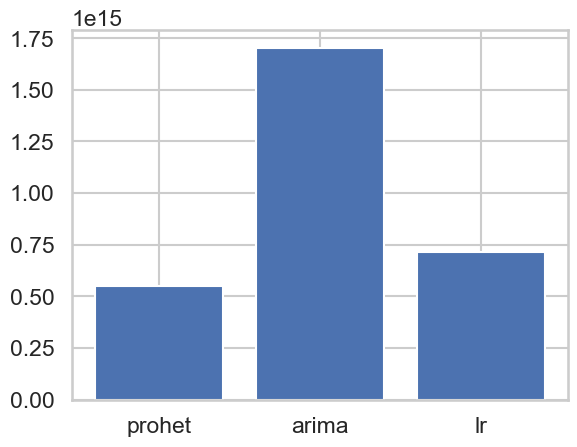

In [109]:
# Define features and target
X_train = train[['lag1', 'lag2', 'lag3']]
y_train = train['y']
X_test = test[['lag1', 'lag2', 'lag3']]
y_test = test['y'] # y actual vals 

# x = df[['lag1', 'lag2', 'lag3']]
# y = df['y']

# Initialize and train the linear model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
predictions_train = model.predict(X_train)

# # Evaluate the model
lr_mse_train = mean_squared_error(np.exp(y_test), np.exp(predictions))
print(f'Mean Squared Error: \n{mse}')

prophet_mse_train = 549853480315220.25
arima_mse_train = 1705112707308218.50
print(prophet_mse_train, arima_mse_train, lr_mse_train)
plt.bar(height = [prophet_mse_train, arima_mse_train, mse_train], x = ['prohet', 'arima', 'lr'])
prophet_mse_train - mse_train # mse is larger than 

(array([ 5113.,  6574.,  8035.,  9496., 10957., 12418., 13879., 15340.,
        16801., 18262., 19723.]),
 [Text(5113.0, 0, '1984'),
  Text(6574.0, 0, '1988'),
  Text(8035.0, 0, '1992'),
  Text(9496.0, 0, '1996'),
  Text(10957.0, 0, '2000'),
  Text(12418.0, 0, '2004'),
  Text(13879.0, 0, '2008'),
  Text(15340.0, 0, '2012'),
  Text(16801.0, 0, '2016'),
  Text(18262.0, 0, '2020'),
  Text(19723.0, 0, '2024')])

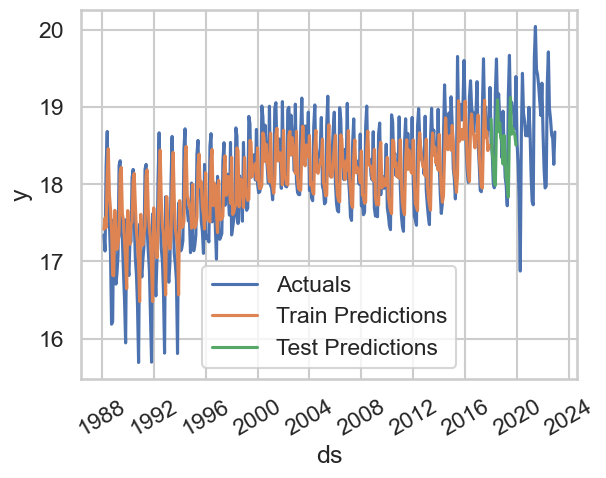

In [116]:
sns.lineplot(data = df , x='ds', y='y', label= 'Actuals')
sns.lineplot(x=train['ds'], y=predictions_train, label='Train Predictions')
sns.lineplot(x=test['ds'], y=predictions, label='Test Predictions')
plt.xticks(rotation=30)
# plt.title('US export value')

## Plot both models

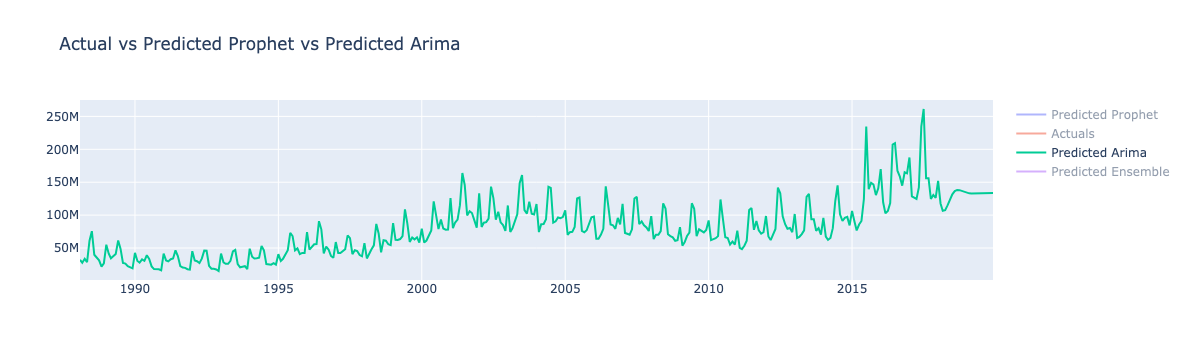

In [43]:
## plot predicted values against actuals, for test range (2018 and 2019 only)
fig = go.Figure()
x_vals1 = df_compare['ds']


# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= df_compare['y-predicted'], name = 'Predicted Prophet'
))
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= df_compare['y-actual'], name = 'Actuals'
))
fig.add_trace(go.Scatter(
    x=x_vals1,
    y= df_compare['predicted_value_arima'], name = 'Predicted Arima'
))

fig.add_trace(go.Scatter(
    x=x_vals1,
    y= df_compare['ensemble-pred'], name = 'Predicted Ensemble'
))
fig.update_layout(title='Actual vs Predicted Prophet vs Predicted Arima')

# fig.add_trace(go.Scatter(x=x_vals1, y=model_eval_exp['yhat_upper'],
#     fill=None,
#     mode='lines',
#     line_color='royalblue',line_width=0, name='Predicted Lower'
#     ))
# fig.add_trace(go.Scatter(
#     x=x_vals1, y=model_eval_exp['yhat_lower'],
#     fill='tonexty', # fill area between trace0 and trace1
#     mode='lines', line_color='royalblue', line_width=0, name='Predicted Upper'))

fig.show()

### metrics 

In [31]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''take in true(actual) and predicted values to calculate the MAPE score. 
    MAPE = mean absolute percentage error'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    result = np.mean(np.abs((y_true - y_pred) / y_true))
    return result

In [32]:
# RMSE - PROPHET - 1988 to 2017 TRAIN RANGE

y_actual_train = df_year_filter(df_compare, 1988, 2017)['y-actual']
y_pred_train = df_year_filter(df_compare, 1988, 2017)['y-predicted']


mse_train = mean_squared_error(y_actual_train, y_pred_train, squared=True)
rmse_train =  mean_squared_error(y_actual_train, y_pred_train, squared=False)
mape_train = mean_absolute_percentage_error(y_actual_train, y_pred_train)
# print(f'Train Prophet MSE value is {mse_train: ,.2f}, years 1988 to 2017')
# print(f'Train Prophet RMSE value is {rmse_train : ,.2f}, years 1988 to 2017')
# print(f'Train Prophet MAPE value is {mape_train: ,.5f}, years 1988 to 2017')

# RMSE - PROPHET - 2018 to 2019 TEST RANGE
y_actual_test = df_year_filter(df_compare, 2018, 2019)['y-actual']
y_pred_test = df_year_filter(df_compare, 2018, 2019)['y-predicted']


mse_test = mean_squared_error(y_actual_test, y_pred_test, squared=True)
rmse_test =  mean_squared_error(y_actual_test, y_pred_test, squared=False)
mape_test = mean_absolute_percentage_error(y_actual_test, y_pred_test)
# print(f'TEST Prophet MSE value is {mse_test: ,.2f}, years 2018 to 2019')
# print(f'TEST Prophet RMSE value is {rmse_test : ,.2f}, years 2018 to 2019')
# print(f'TEST Prophet MAPE value is {mape_test: ,.5f}, years 2018 to 2019')
prophet_vals = [mse_train, mse_test, rmse_train, rmse_test, mape_train, mape_test]

In [33]:
# RMSE - ARIMA - 1988 to 2017 TRAIN RANGE *

y_actual_train = df_year_filter(df_compare, 1988, 2017)['y-actual']
y_pred_train = df_year_filter(df_compare, 1988, 2017)['predicted_value_arima']

mse_train = mean_squared_error(y_actual_train, y_pred_train, squared=True)
rmse_train =  mean_squared_error(y_actual_train, y_pred_train, squared=False)
mape_train = mean_absolute_percentage_error(y_actual_train, y_pred_train)
# print(f'Train ARIMA MSE value is {mse_train: ,.2f}, years 1988 to 2017')
# print(f'Train ARIMA RMSE value is {rmse_train : ,.2f}, years 1988 to 2017')
# print(f'Train ARIMA MAPE value is {mape_train: ,.5f}, years 1988 to 2017')

# RMSE - ARIMA - 2018 to 2019 TEST RANGE
y_actual_test = df_year_filter(df_compare, 2018, 2019)['y-actual']
y_pred_test = df_year_filter(df_compare, 2018, 2019)['predicted_value_arima']


mse_test = mean_squared_error(y_actual_test, y_pred_test, squared=True)
rmse_test =  mean_squared_error(y_actual_test, y_pred_test, squared=False)
mape_test = mean_absolute_percentage_error(y_actual_test, y_pred_test)
# print(f'TEST ARIMA MSE value is {mse_test: ,.2f}, years 2018 to 2019')
# print(f'TEST ARIMA RMSE value is {rmse_test : ,.2f}, years 2018 to 2019')
# print(f'TEST ARIMA MAPE value is {mape_test: ,.5f}, years 2018 to 2019')
arima_vals = [mse_train,mse_test, rmse_train, rmse_test, mape_train, mape_test]

In [44]:
# RMSE - ENSEMBLE - 1988 to 2017 TRAIN RANGE *

y_actual_train = df_year_filter(df_compare, 1988, 2017)['y-actual']
y_pred_train = df_year_filter(df_compare, 1988, 2017)['ensemble-pred']

mse_train = mean_squared_error(y_actual_train, y_pred_train, squared=True)
rmse_train =  mean_squared_error(y_actual_train, y_pred_train, squared=False)
mape_train = mean_absolute_percentage_error(y_actual_train, y_pred_train)
# print(f'Train ARIMA MSE value is {mse_train: ,.2f}, years 1988 to 2017')
# print(f'Train ARIMA RMSE value is {rmse_train : ,.2f}, years 1988 to 2017')
# print(f'Train ARIMA MAPE value is {mape_train: ,.5f}, years 1988 to 2017')

# RMSE - ARIMA - 2018 to 2019 TEST RANGE
y_actual_test = df_year_filter(df_compare, 2018, 2019)['y-actual']
y_pred_test = df_year_filter(df_compare, 2018, 2019)['ensemble-pred']

mse_test = mean_squared_error(y_actual_test, y_pred_test, squared=True)
rmse_test =  mean_squared_error(y_actual_test, y_pred_test, squared=False)
mape_test = mean_absolute_percentage_error(y_actual_test, y_pred_test)
# print(f'TEST ARIMA MSE value is {mse_test: ,.2f}, years 2018 to 2019')
# print(f'TEST ARIMA RMSE value is {rmse_test : ,.2f}, years 2018 to 2019')
# print(f'TEST ARIMA MAPE value is {mape_test: ,.5f}, years 2018 to 2019')
ensemble_vals = [mse_train,mse_test, rmse_train, rmse_test, mape_train, mape_test]

PRioritize MAPE as the METRIC

In [45]:
results = pd.DataFrame(data={'Prophet':prophet_vals, 'ARIMA':arima_vals, 'Ensemble':ensemble_vals}, index = ['mse_train', 'mse_test', 'rmse_train', 'rmse_test', 'mape_train', 'mape_test'])

In [46]:
results

Prophet                    ARIMA  \
mse_train    549,853,480,315,220.25 1,705,112,707,308,218.50   
mse_test   2,683,968,874,187,328.50 6,748,189,029,322,979.00   
rmse_train            23,448,954.78            41,293,010.39   
rmse_test             51,807,034.99            82,147,361.67   
mape_train                     0.21                     0.38   
mape_test                      0.32                     0.44   

                           Ensemble  
mse_train    717,028,313,456,291.88  
mse_test   1,470,508,528,629,499.25  
rmse_train            26,777,384.37  
rmse_test             38,347,210.18  
mape_train                     0.25  
mape_test                      0.29

## Summary:


* Despite the Prophet model's overfit to training data since scores are better in training than testing, it still scores better than the baseline arima model
* Refine Prophet model and address overfitting. Prophet overall has lower scores. So go with that model.
* Since prophet predictions appeared to overestimate predictions and arima underestimated predictions, I also added in a simple ensemble method of the mean (average) of these two to see how their metrics would compare. 
* Flaws: the data has seasonality however in these baseline models, parameter tuning was not implemented, as a result, ARIMA's forecast does not account for seasonality and is linear as a result.
* Next step: optimize predictive model using hyperparam tuning, cross validation and same date range. 

In [37]:
# best_prophet_params = results.copy()
# best_prophet_params